## Machine Learning Operations (MLOps)

In [1]:
from IPython.core.display import HTML

def load_css():
    styles = open("css/custom.css", "r").read()
    return HTML(f"<style>{styles}</style>")

load_css()

## Importando os pacotes do projeto
Vamos centralizar nesta célula a importação de todos os pacotes que iremos utilizar neste notebook

In [2]:
from pathlib import Path
import sys 
import os

current_path = Path(os.getcwd())
parent_path = current_path.parent.absolute()
sys.path.append(str(parent_path))

import json 
import folium
import numpy as np
from sklearn.cluster import KMeans
import random
import brazilcep
from geopy.geocoders import Nominatim
import geopy.distance
from yellowbrick.cluster import KElbowVisualizer
from joblib import dump, load
import json
import matplotlib.pyplot as plt
from matplotlib import gridspec
from commons.utils import plot_points, get_delivery_coordinates, load_training_data, prepare_points
from mlflow.models import infer_signature
from mlflow import MlflowClient
import mlflow
import json
import requests
import warnings
warnings.filterwarnings('ignore')

<div class="custom-slide">
    <div class="hands-on">
        Revisão da parte 1
    </div>
</div>

## Carregando nossos dados de treino

In [3]:
instances = load_training_data(path_str = "../data/train/")

Foram carregados 50 arquivos
O objeto instances é do tipo <class 'list'>


## Prepara os dados de treino

In [4]:
points = prepare_points(instances)

In [5]:
points[0]

{'lng': -47.7609277270516,
 'lat': -15.65246980577859,
 'color': 'blue',
 'cluster': None,
 'dist': None}

<div class="custom-slide">
    <h1>Modularização de código</h1>
    <p>Percebeu que começemos a encapsular nosso código em funções? Essa é uma boa prática enquanto estamos explorando o problema e começando a formatar nosso modelo. Isso também nos ajuda a evitar cópia de código ao longo do projeto, o que pode facilmente pode resultar em um ambiente exploratório totalmente desorganizado e sem reproducividade.</p>
    <p>Quando terminarmos a análise exploratória do problema no jupyter notebook, provavelmente já teremos boa parte da lógica do modeo organizada em funções reutilizáveis :)</p>
</div>

<div class="custom-slide">
    <div class="hands-on">
        Continuando nossa implementação
    </div>
</div>

## Treinando o modelo de clustering
Já temos um dataset de treino preparado, no qual existem vários pontos de entregas já realizadas. Agora iremos usar este dataset para segmentar essas entregas em clusters. 

Veja que `points`é uma lista de dicionários. Precisamos convertê-la em uma `numpy.ndarray` para usarmos estes dados de entrada no algoritmo de clustering.

In [6]:
points[0:5]

[{'lng': -47.7609277270516,
  'lat': -15.65246980577859,
  'color': 'blue',
  'cluster': None,
  'dist': None},
 {'lng': -47.75734733959318,
  'lat': -15.65030404766782,
  'color': 'blue',
  'cluster': None,
  'dist': None},
 {'lng': -47.738174492381134,
  'lat': -15.668652995146136,
  'color': 'blue',
  'cluster': None,
  'dist': None},
 {'lng': -47.75666348246043,
  'lat': -15.646774118576014,
  'color': 'blue',
  'cluster': None,
  'dist': None},
 {'lng': -47.757018902295506,
  'lat': -15.650018577014293,
  'color': 'blue',
  'cluster': None,
  'dist': None}]

In [7]:
# Preparando os dados para o modelo de clustering
input_points = [ (p['lat'], p['lng']) for p in points]
input_points = np.array(input_points)
input_points[0:5]

array([[-15.65246981, -47.76092773],
       [-15.65030405, -47.75734734],
       [-15.668653  , -47.73817449],
       [-15.64677412, -47.75666348],
       [-15.65001858, -47.7570189 ]])

Agora sim!

Um dos primeiros passos de um modelo de clustering é estudar a quantidade ideal de grupos (k). Um dos métodos mais utilizados é conhecido como Elbow method.

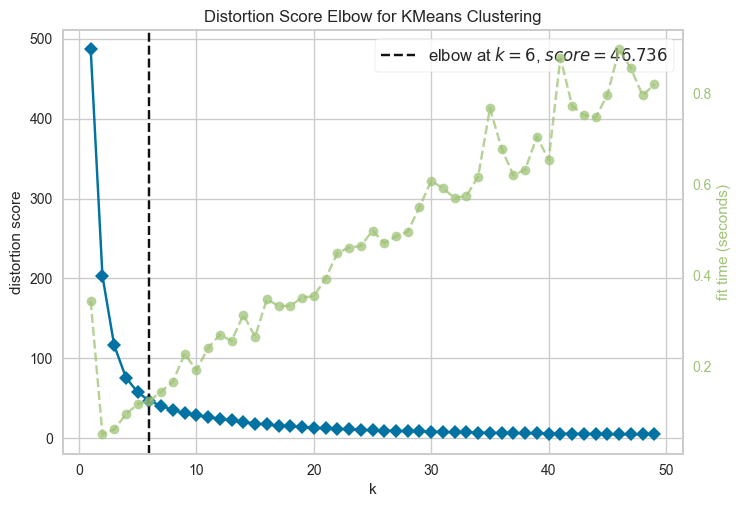

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
# Define o modelo base
model = KMeans()

# Cria um visualizer 
visualizer = KElbowVisualizer(model, k=(1,50))

# Treino vários modelos de clustering
visualizer.fit(input_points)

# Visualiza os resultados
visualizer.show()

Veja que podemos extrair as informações do visualizer

In [9]:
print('O número ideal de cluster é {}'.format(visualizer.elbow_value_))
print('O SSE encontrado foi {}'.format(visualizer.elbow_score_))

O número ideal de cluster é 6
O SSE encontrado foi 46.73600862419016


Vamos criar uma variável para definir o número de clusters do nosso modelo

In [10]:
n_clusters = visualizer.elbow_value_

Agora sim, podemos treinar o modelo de clustering com `input_points`

In [11]:
# Treina o modelo de clustering
model = KMeans(n_clusters = n_clusters, random_state = 0).fit(input_points)

# Associa clusters com cada observação de treino
predictions = model.predict(input_points)

## Exibe o resultado do modelo no mapa

Para exibir nosso modelo de clustering no mapa, vamos definir uma cor para cada cluster criado. 
A ideia é definir a cor de cada ponto de acordo com o seu cluster

In [12]:
# Cria uma função para gerar cores aleatórias
get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]

Exemplo para retornar uma lista de cores

In [13]:
colors = get_colors(n_clusters)
colors

['#5f00f3', '#c37bdd', '#eff372', '#3e39ca', '#09d2d3', '#1718ec']

Agora vamos preparar um colormap, no qual vamos associar uma cor para cada cluster

In [14]:
cm = dict()
for cluster in np.unique(model.labels_):
    cm[cluster] = colors[cluster]

cm

{0: '#5f00f3',
 1: '#c37bdd',
 2: '#eff372',
 3: '#3e39ca',
 4: '#09d2d3',
 5: '#1718ec'}

In [15]:
# Preparando os marcadores do mapa
markers = []
for i, center in enumerate(model.cluster_centers_):
    m = dict()
    m['lat'] = center[0]
    m['lng'] = center[1]
    m['cluster'] = i
    m['color'] = 'black'
    m['type'] = ['cluster', 'pin']
    m['tooltip'] = 'Cluster {}'.format(i)
    markers.append(m)
    
markers

[{'lat': -15.623188710465486,
  'lng': -47.65238397469197,
  'cluster': 0,
  'color': 'black',
  'type': ['cluster', 'pin'],
  'tooltip': 'Cluster 0'},
 {'lat': -15.649745950686997,
  'lng': -47.7902749412903,
  'cluster': 1,
  'color': 'black',
  'type': ['cluster', 'pin'],
  'tooltip': 'Cluster 1'},
 {'lat': -15.757037977498,
  'lng': -47.771612075032984,
  'cluster': 2,
  'color': 'black',
  'type': ['cluster', 'pin'],
  'tooltip': 'Cluster 2'},
 {'lat': -15.890221773669836,
  'lng': -47.497399544416034,
  'cluster': 3,
  'color': 'black',
  'type': ['cluster', 'pin'],
  'tooltip': 'Cluster 3'},
 {'lat': -15.603417375334981,
  'lng': -47.917044479085696,
  'cluster': 4,
  'color': 'black',
  'type': ['cluster', 'pin'],
  'tooltip': 'Cluster 4'},
 {'lat': -15.65940145501782,
  'lng': -47.837297176334864,
  'cluster': 5,
  'color': 'black',
  'type': ['cluster', 'pin'],
  'tooltip': 'Cluster 5'}]

Finalmente, iremos associar os clusters e cores a cada ponto, assim como criar marcadores para mostrar os centróides de cada cluster no mapa

In [16]:
# Preparando os pontos do mapa
for p in points:
    cluster = model.predict([[ p['lat'], p['lng'] ]] )
    c = cluster[0]
    p['cluster'] = c
    p['color'] = cm[c]

    # Calcula a distância do ponto para o seu cluster
    coord_p = (p['lat'], p['lng'])
    coord_cluster = (markers[c]['lat'], markers[c]['lng'])
    p['dist'] = geopy.distance.geodesic(coord_p, coord_cluster).km

points[0:5]

[{'lng': -47.7609277270516,
  'lat': -15.65246980577859,
  'color': '#c37bdd',
  'cluster': 1,
  'dist': 3.160956832617973},
 {'lng': -47.75734733959318,
  'lat': -15.65030404766782,
  'color': '#c37bdd',
  'cluster': 1,
  'dist': 3.5309949920310046},
 {'lng': -47.738174492381134,
  'lat': -15.668652995146136,
  'color': '#c37bdd',
  'cluster': 1,
  'dist': 5.96484320841163},
 {'lng': -47.75666348246043,
  'lat': -15.646774118576014,
  'color': '#c37bdd',
  'cluster': 1,
  'dist': 3.61878072808948},
 {'lng': -47.757018902295506,
  'lat': -15.650018577014293,
  'color': '#c37bdd',
  'cluster': 1,
  'dist': 3.5657996089447535}]

In [ ]:
# Exibe todos os dados de treino no mapa
m = plot_points(points = points, markers = markers)
m

## Salvando o modelo em disco

In [ ]:
# Salva o arquivo em disco
dump(model, '../temp/clustering_model.joblib') 

# Lê o arquivo do disco
model_new = load('../temp/clustering_model.joblib') 
model_new

<div class="custom-slide">
    <h1>Artefatos do modelo</h1>
    <p>
       Veja que treinamos um modelo de clustering (usando o sklearn) e o salvamos em disco. É exatamente este arquivo que precisar ser acessado posteriormente para implementação do pipeline de inferência do modelo (o que aprendemos como model serving). 
    </p>
    <p>
       Vamos tirar um tempo agora para pensar em alguns desafios que você teria para efetivamente salvar este modelo de forma organizada:
    </p>
    <ul>
        <li>
            Versionamento: pra começar, seria interessante versionar este modelo. Assim você poderia restaurar um modelo anterior, caso seja necessário.
        </li>
        <li>
            Durante o processo de desenvolvimento deste modelo, criamos gráficos e outras análises que poderiam ser armazenadas juntamente com o modelo para referência futura. Isso pode ajudar na interpretabilidade do modelo.
        </li>
        <li>
            Também realizamos um otimização pequena análise de hyperparâmetros do modelo, no qual identificamos o número ideal de clusters de acordo com o método Elbow. Será que também não seria interessante armazanar os resultados das otimizações do modelo?
        </li>
    </ul>   

Aqui começamos a ser expostos aos desafios reais de machine learning. Em projetos pequenos, muitas vezes os pontos acima são negligenciados; porém, é praticamente impossível escalar um ambiente de ML sem pensar nestes pontos. Afinal, parece que não basta apenas salvar o modelo em disco e usá-lo depois, o problema parece maior.
    <p>
       Ainda vamos falar sobre as estratégias para organizar os artefatos no nosso modelo. Antes disso, vamos continuar com a implementação do projeto, pois nem sempre um modelo é composto por apenas um algoritmo de ML, a vida real é um pouco mais dura que isso...
    </p>
</div>